# Mathematics in Machine Learning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

#import dataframe
df = pd.read_csv('.\data\MMLdata.csv', sep=";")

## General statistics

In [2]:
print("Total lenght: " + str(len(df)))
print("Number of features: " + str(len(df.columns)-1))

# does our model contains any nan value?
print("Are there nan values?", str(df.isnull().values.any()))

Total lenght: 2126
Number of features: 25
Are there nan values? False


## Multi-Classification or Binary-Classification?
## Balance or unbalance?

normal: 1655
suspect: 295
pathologic: 176


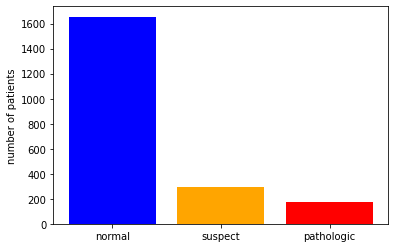

normal: 1655
pathologic: 471


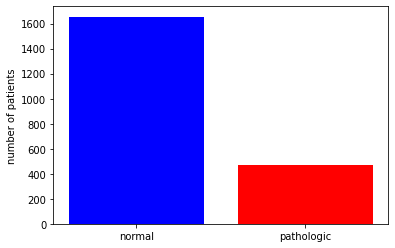

In [3]:
# NSP
# N = normal, S = suspect P = pathologic
# N = 1, S = 2, P = 3
normal = len(df[df['NSP']==1])
suspect = len(df[df['NSP']==2])
pathologic = len(df[df['NSP']==3])

print("normal: " + str(normal))
print("suspect: " + str(suspect))
print("pathologic: " + str(pathologic))

plt.bar('normal', normal, color='blue')
plt.bar('suspect', suspect, color='orange')
plt.bar('pathologic', pathologic, color='red')
plt.ylabel('number of patients')
plt.show()

# considering a binary problem
df.loc[df.NSP==1, 'NSP'] = 0
df.loc[df.NSP==2, 'NSP'] = 1
df.loc[df.NSP==3, 'NSP'] = 1

normal = len(df[df['NSP']==0])
pathologic = len(df[df['NSP']==1])

print("normal: " + str(normal))
print("pathologic: " + str(pathologic))

plt.bar('normal', normal, color='blue')
plt.bar('pathologic', pathologic, color = 'red')
plt.ylabel('number of patients')
plt.show()

In [4]:
# remove useless attributes
df = df.drop(columns=['b','e']) # this represent the time of the exam
df = df.drop(columns=['DR'])    # all of the values are 0

## Splitting dataset

In [5]:
target = df['NSP']
df = df.drop(columns='NSP')

In [6]:
# dividing train and test
X_train, X_test, y_train, y_test = train_test_split(df, target, train_size = 0.9, random_state = 42, shuffle = True)

## Feature exploration

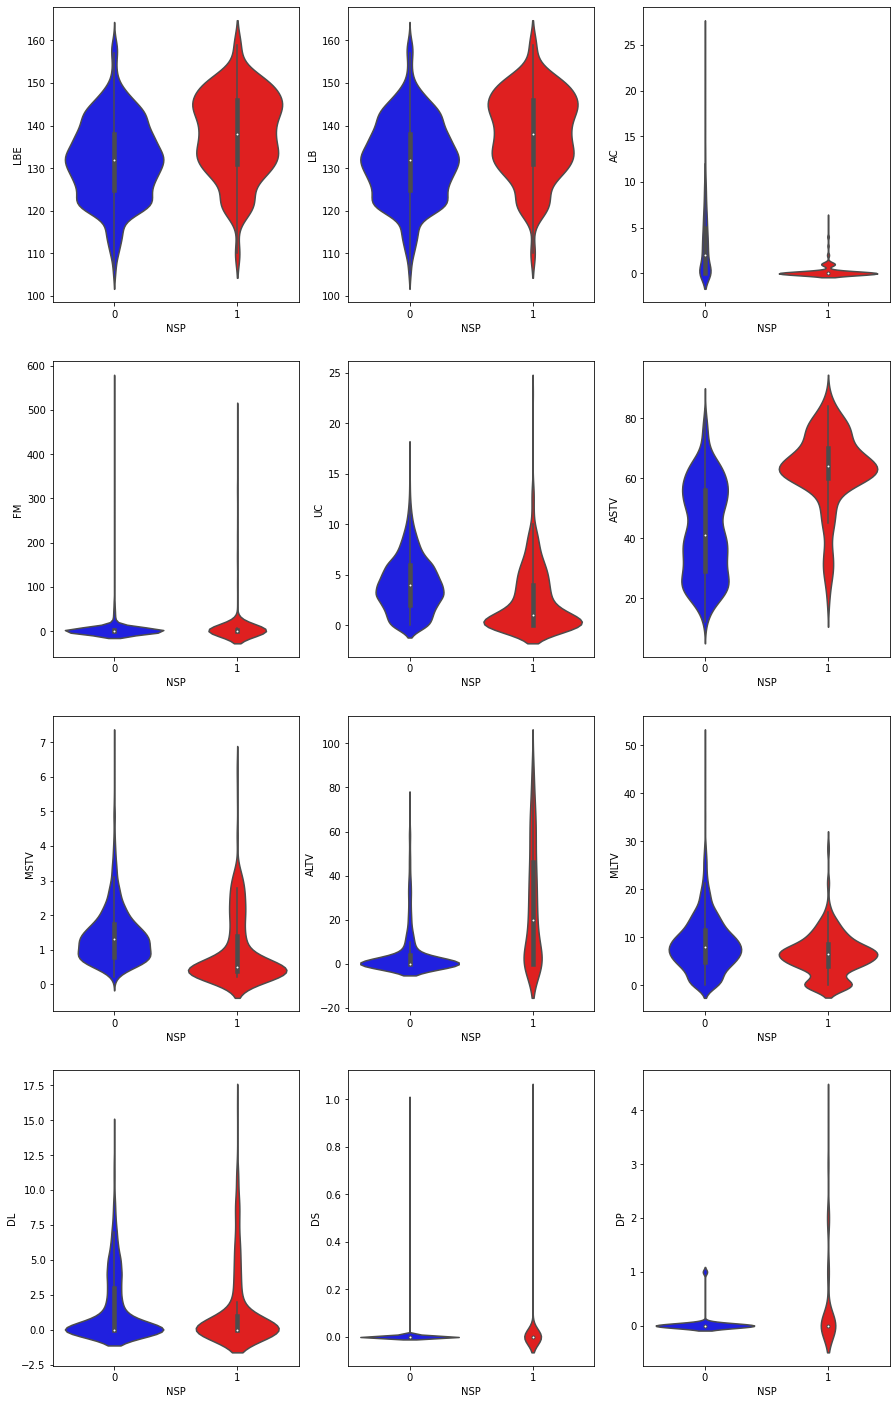

In [7]:
# just some example to show feature distribution

df['NSP'] = target

fig, positions = plt.subplots(4, 3, figsize=(15,25))
y = 0
my_pal = {0: "b", 1: "r"}
for val in df.columns:
    i, j = divmod(y, 3)
    if i==4: break
    sns.violinplot(x = 'NSP', y = val, data = df, ax = positions[i, j], palette=my_pal)
    positions[i, j].set_ylabel(val)
    y = y + 1

## Feature Correlation

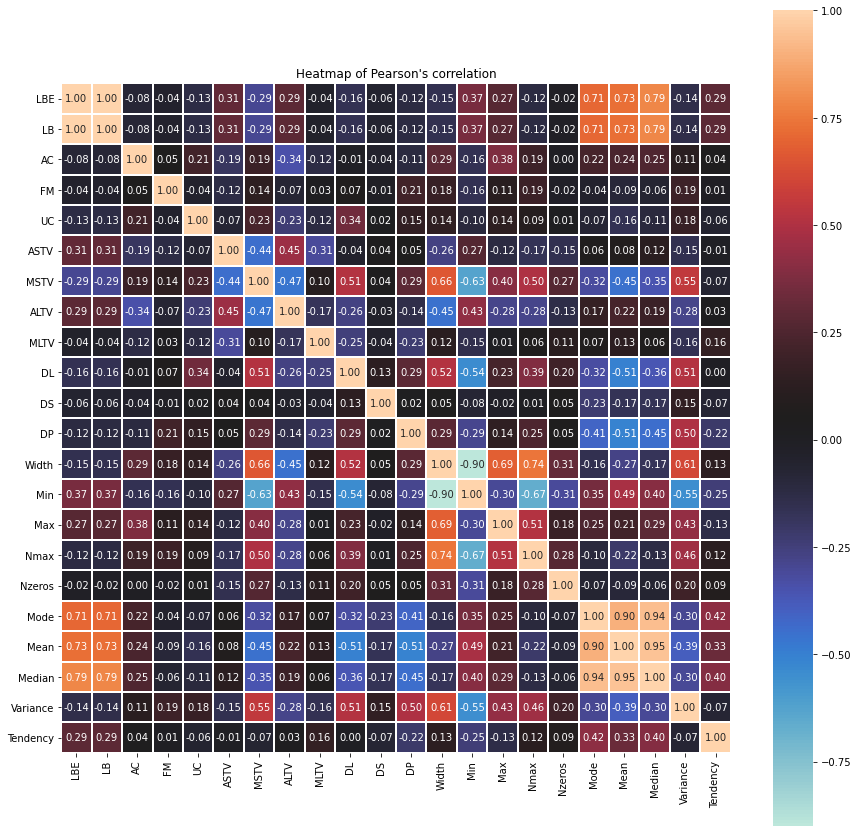

In [8]:
# The Pearson's correlation coefficient matrix
peco = X_train.corr(method = 'pearson')
fig, ax = plt.subplots(figsize = (15,15))
ax.set_title("Heatmap of Pearson's correlation")
ax = sns.heatmap(peco, linewidths = 1, annot = True, cmap="icefire", fmt = '.2f', square = True)

In [9]:
matrix = X_train.corr().abs()
#puts NaN values to the upper half and diagonal of the matrix
mask = np.triu(np.ones_like(matrix, dtype=bool))
reduced_matrix = matrix.mask(mask)
#find columns that meet the 0.80 threshold
to_drop = [c for c in reduced_matrix.columns if any(reduced_matrix[c] >= 0.8)]
print("Given our threshold of .80, drop a total number of: " + str(len(to_drop)) + " features")
#drop the cols
X_train = X_train.drop(to_drop, axis=1)
print("The features to drop are: " + str(to_drop))

Given our threshold of .80, drop a total number of: 4 features
The features to drop are: ['LBE', 'Width', 'Mode', 'Mean']


In [10]:
# remove the same features on the test set
X_test = X_test[X_train.columns]

## Outlier detection

In [11]:
clf = IsolationForest(random_state=0, contamination=0.05).fit(X_train)
v = clf.fit_predict(X_train)

unique, counts = np.unique(v, return_counts=True)
values = dict(zip(unique, counts))

print("Numbers of outliers   : " + str(values[-1]))
print("Numbers of inliers    : " + str(values[1]))
print("Percentage of outliers: " + str(round(values[-1]/(values[-1]+values[1])*100,2)))
print("Percentage of inliers : " + str(round(values[1]/(values[-1]+values[1])*100,2)))

Numbers of outliers   : 96
Numbers of inliers    : 1817
Percentage of outliers: 5.02
Percentage of inliers : 94.98


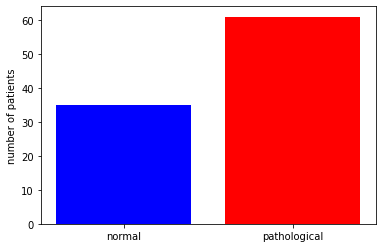

In [12]:
X_train['outlier'] = v
X_train['label'] = y_train

df_out = X_train[X_train['outlier']==-1]
df_out

pathological_out = df_out['label'].value_counts()[1]
normal_out = df_out['label'].value_counts()[0]
normal_out, pathological_out

plt.bar('normal',normal_out, color='blue')
plt.bar('pathological',pathological_out, color='red')
plt.ylabel('number of patients')

X_train = X_train.drop(columns=['outlier', 'label'])

  Patological outliers: 61
       Normal outliers: 35
     Total Patological: 417
          Total normal: 1496
% Patological outliers: 0.15
     % Normal outliers: 0.02


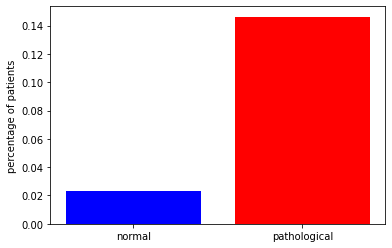

In [13]:
patological_outliers = (df_out['label']==0).value_counts()[0]
normal_outliers = (df_out['label']==0).value_counts()[1]

patological = (y_train==0).value_counts()[0]
normal = (y_train==0).value_counts()[1]

print("  Patological outliers: " + str(patological_outliers))
print("       Normal outliers: " + str(normal_outliers))
print("     Total Patological: " + str(patological))
print("          Total normal: " + str(normal))
print("% Patological outliers: " + str(round(patological_outliers/patological,2)))
print("     % Normal outliers: " + str(round(normal_outliers/normal,2)))

plt.bar('normal', normal_outliers/normal , color='blue')
plt.bar('pathological',patological_outliers/patological , color='red')
plt.ylabel('percentage of patients')
plt.show()

## Normalize the Dataset

In [14]:
X_test  = (X_test  - X_train.mean())/X_train.std()
X_train = (X_train - X_train.mean())/X_train.std()

## Dimensionality reduction

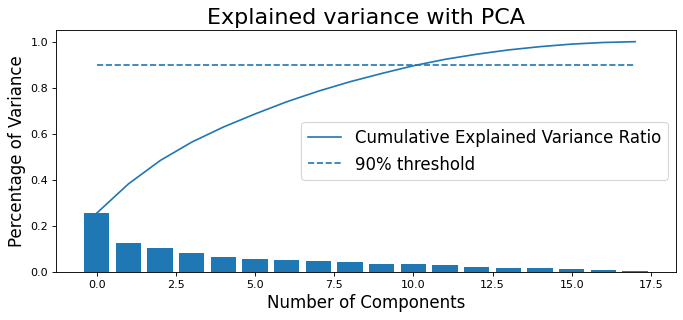

Number of componenst to reach 90% threshold: 11


In [15]:
pca = PCA()
pca.fit(X_train)
PCA()
evr = pca.explained_variance_ratio_
# print(pca.explained_variance_ratio_.round(3))
# print(pca.singular_values_.round(2))

plt.figure(figsize=(10, 4), dpi=80)
x = np.arange(0,len(evr),1)
plt.bar(x, evr)
cum_sum = evr.cumsum()
plt.plot(x, cum_sum)
plt.title("Explained variance with PCA", fontsize=20)
plt.hlines(0.9, 0, 17, linestyle='dashed')
plt.xlabel("Number of Components", fontsize=15)
plt.ylabel("Percentage of Variance", fontsize=15)
plt.legend(['Cumulative Explained Variance Ratio', '90% threshold'], loc=7, fontsize=15)
plt.show()

number_of_components = 0
i=0
for i in range(len(cum_sum)):
    if cum_sum[i]>=0.90:
        number_of_components = i
        break
print("Number of componenst to reach 90% threshold: " + str(number_of_components))

## Balance dataset

The unbalanced set was composed by 1913 elements.
X_train_smote is composed of 2992 elements.


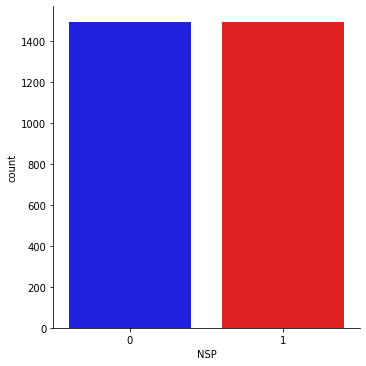

In [16]:
sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
print(f"The unbalanced set was composed by {len(X_train)} elements.")
print(f"X_train_smote is composed of {len(X_train_smote)} elements.")
copia = X_train_smote.copy(deep = True)
copia['NSP'] = y_train_smote
_ = sns.catplot(x = 'NSP', kind = 'count', data = copia, palette=my_pal)

## SVM

In [17]:
# SVM
# Normalized data + PCA + SMOTE
# CODE MUST BE ADAPTED TO PERFORM THE DIFFERENT PIPELINES

PCA
pca = PCA(n_components=10)
pca.fit(X_train)

X_train_pca = pca.fit_transform(X_train)

SMOTE
sm = SMOTE()
X_train_pca_smote, y_train_pca_smote = sm.fit_resample(X_train_pca, y_train)
    

# SVM
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[1, 10]}
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring='f1')
clf.fit(X_train_pca_smote, y_train_pca_smote)

print("The best hyperparameters are" + str(clf.best_params_))
print("The f1 score is: " + str(clf.best_score_))
print()

kf = KFold(n_splits=5)
kf.get_n_splits(X_train)
f1_final = []
conf_final = []

for train_index, test_index in kf.split(X_train):
    X_t = X_train.iloc[train_index]
    y_t = y_train.iloc[train_index]
    
    X_v = X_train.iloc[test_index]
    y_v = y_train.iloc[test_index]
    
    # PCA
    pca = PCA(n_components=10)
    pca.fit(X_t)

    X_t = pca.fit_transform(X_t)
    X_v = pca.transform(X_v)
    
        
    # SMOTE
    sm = SMOTE()
    X_t, y_t = sm.fit_resample(X_t, y_t)
    
    # SVM
    svc = SVC(C=10, kernel='rbf')
    svc.fit(X_t, y_t)
    y_pred = svc.predict(X_v)

    f1 = f1_score(y_v, y_pred)
    print("The F1 measure is: " + str(f1), end="\n\n")
    
    confm = confusion_matrix(y_v, y_pred)
    conf_final.append(confm)
    
    f1_final.append(f1)
    
print("On average the F1 score of Decision Tree is: " + str(sum(f1_final)/len(f1_final)))

The best hyperparameters are{'C': 10, 'kernel': 'rbf'}
The f1 score is: 0.9464965269730186

The F1 measure is: 0.8295454545454546

The F1 measure is: 0.7597765363128491

The F1 measure is: 0.8071748878923767

The F1 measure is: 0.7857142857142856

The F1 measure is: 0.8363636363636364

On average the F1 score of Decision Tree is: 0.8037149601657205


The F1 measure is: 0.9174311926605504



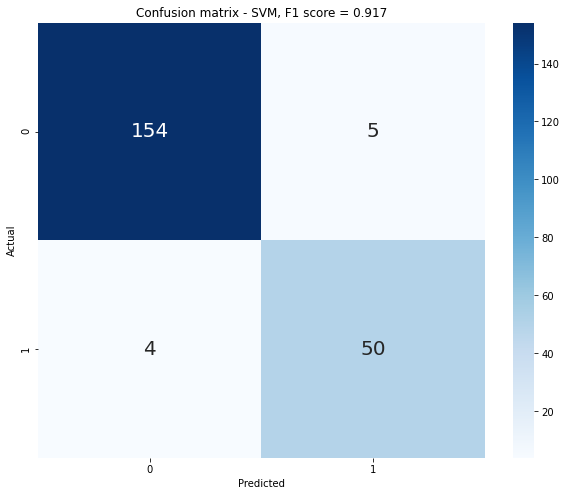

In [18]:
# FINAL RESULT ON TEST SET SVM 
X_t = X_train
y_t = y_train

# SVM
svc = SVC(C=10, kernel='rbf')
svc.fit(X_t, y_t)
y_pred = svc.predict(X_test)

f1 = f1_score(y_test, y_pred)
print("The F1 measure is: " + str(f1), end="\n\n")

columns = [0,1]
confm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10, 8))
plt.title('Confusion matrix - SVM, F1 score = ' + str(round(f1,3)))
df_cm = DataFrame(confm, index = columns, columns = columns)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
ax = sns.heatmap(df_cm, cmap = 'Blues', annot = True, fmt='g', annot_kws={"fontsize":20})
plt.show()

## Decision Trees

#### Due to the main issue of decision trees (overfitting), I decided to directly evaluate Random Forests. RF are more reliable and robust w.r.t. the Trees

## Random Forests

In [19]:
# # RF
# # Normalized data + PCA + SMOTE
# CODE MUST BE ADAPTED TO PERFORM THE DIFFERENT PIPELINES

# PCA
pca = PCA(n_components=10)
pca.fit(X_train)

X_train_pca = pca.fit_transform(X_train)

sm = SMOTE()
X_train_pca_smote, y_train_pca_smote = sm.fit_resample(X_train_pca, y_train)

parameters = {'criterion':('gini', 'entropy'), 'n_estimators':[10, 100], 'max_depth':[5,10,50,100]}
rf = RandomForestClassifier(random_state = 42)
clf = GridSearchCV(rf, parameters, scoring='f1')
clf.fit(X_train_pca_smote, y_train_pca_smote)

print("The best hyperparameters are" + str(clf.best_params_))
print("The f1 score is: " + str(clf.best_score_))
print()

kf = KFold(n_splits=5)
kf.get_n_splits(X_train)
f1_final = []
conf_final = []

for train_index, test_index in kf.split(X_train):
    X_t = X_train.iloc[train_index]
    y_t = y_train.iloc[train_index]
    
    X_v = X_train.iloc[test_index]
    y_v = y_train.iloc[test_index]
    
    # PCA
    pca = PCA(n_components=10)
    pca.fit(X_t)
    
    X_t = pca.fit_transform(X_t)
    X_v = pca.transform(X_v)
    
    # SMOTE
    sm = SMOTE()
    X_t, y_t = sm.fit_resample(X_t, y_t)

    # RF
    rf = RandomForestClassifier(random_state = 42, criterion='entropy', max_depth=50, n_estimators=100)
    rf.fit(X_t, y_t)
    y_pred = rf.predict(X_v)

    f1 = f1_score(y_v, y_pred)
    print("The F1 measure is: " + str(f1), end="\n\n")
    
    confm = confusion_matrix(y_v, y_pred)
    conf_final.append(confm)
    
    f1_final.append(f1)
    
print("On average the F1 score of Decision Tree is: " + str(sum(f1_final)/len(f1_final)))

The best hyperparameters are{'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 100}
The f1 score is: 0.9621919716299276

The F1 measure is: 0.8374999999999999

The F1 measure is: 0.7672955974842767

The F1 measure is: 0.8363636363636363

The F1 measure is: 0.8205128205128205

The F1 measure is: 0.832214765100671

On average the F1 score of Decision Tree is: 0.818777363892281


The F1 measure is: 0.8828828828828829



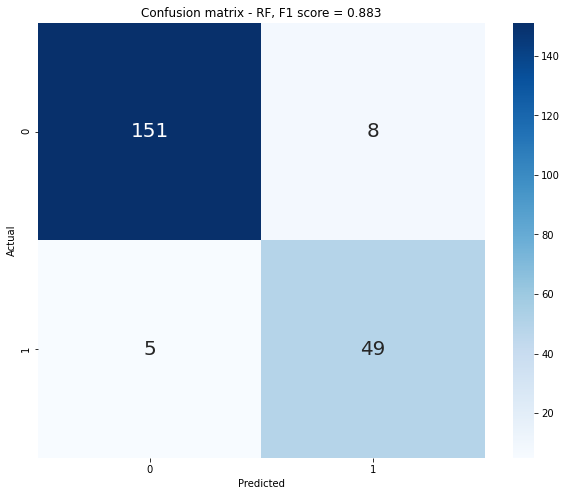

In [20]:
# FINAL RESULT ON TEST SET RF. with SMOTE
sm = SMOTE()
X_t, y_t = sm.fit_resample(X_train, y_train)

# RF
rf = RandomForestClassifier(random_state = 42, criterion='entropy', max_depth=50, n_estimators=100)
rf.fit(X_t, y_t)
y_pred = rf.predict(X_test)

f1 = f1_score(y_test, y_pred)
print("The F1 measure is: " + str(f1), end="\n\n")

columns = [0,1]
confm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10, 8))
plt.title('Confusion matrix - RF, F1 score = ' + str(round(f1,3)))
df_cm = DataFrame(confm, index = columns, columns = columns)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
ax = sns.heatmap(df_cm, cmap = 'Blues', annot = True, fmt='g', annot_kws={"fontsize":20})
plt.show()

## K-Nearest Neighbors

In [21]:
# # KNN
# # Normalized data + PCA + SMOTE
# CODE MUST BE ADAPTED TO PERFORM THE DIFFERENT PIPELINES

# PCA
pca = PCA(n_components=10)
pca.fit(X_train)

X_train_pca = pca.fit_transform(X_train)

sm = SMOTE()
X_train_pca_smote, y_train_pca_smote = sm.fit_resample(X_train_pca, y_train)

parameters = {'weights':('uniform', 'distance'), 'n_neighbors':[3, 5, 7, 11]}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, scoring='f1')
clf.fit(X_train_pca_smote, y_train_pca_smote)

print("The best hyperparameters are" + str(clf.best_params_))
print("The f1 score is: " + str(clf.best_score_))
print()

kf = KFold(n_splits=5)
kf.get_n_splits(X_train)
f1_final = []
conf_final = []

for train_index, test_index in kf.split(X_train):
    X_t = X_train.iloc[train_index]
    y_t = y_train.iloc[train_index]
    
    X_v = X_train.iloc[test_index]
    y_v = y_train.iloc[test_index]
    
    # PCA
    pca = PCA(n_components=10)
    pca.fit(X_t)
    
    X_t = pca.fit_transform(X_t)
    X_v = pca.transform(X_v)
    
    # SMOTE
    sm = SMOTE()
    X_t, y_t = sm.fit_resample(X_t, y_t)

    # KNN
    knn = KNeighborsClassifier(weights='uniform', n_neighbors=3)
    knn.fit(X_t, y_t)
    y_pred = knn.predict(X_v)


    f1 = f1_score(y_v, y_pred)
    print("The F1 measure is: " + str(f1), end="\n\n")
    
    confm = confusion_matrix(y_v, y_pred)
    conf_final.append(confm)
    
    f1_final.append(f1)
    
print("On average the F1 score of Decision Tree is: " + str(sum(f1_final)/len(f1_final)))

The best hyperparameters are{'n_neighbors': 3, 'weights': 'distance'}
The f1 score is: 0.9587189134377259

The F1 measure is: 0.8342857142857143

The F1 measure is: 0.7999999999999999

The F1 measure is: 0.8333333333333333

The F1 measure is: 0.788235294117647

The F1 measure is: 0.8695652173913043

On average the F1 score of Decision Tree is: 0.8250839118255998


The F1 measure is: 0.8099173553719008



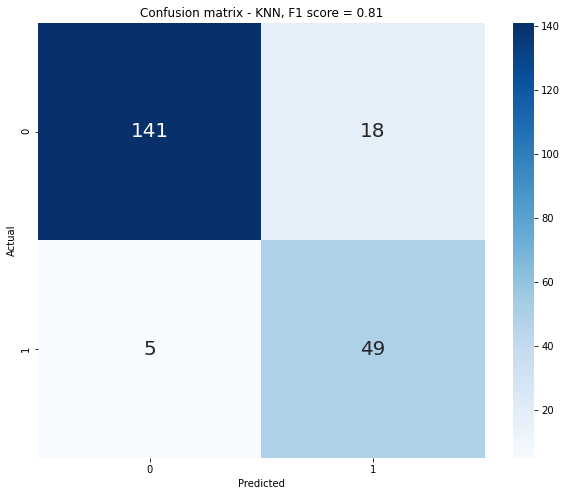

In [22]:
# FINAL RESULT ON TEST SET. KNN with PCA and SMOTE

pca = PCA(n_components=10)
pca.fit(X_train)

X_t = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

sm = SMOTE()
X_t, y_t = sm.fit_resample(X_t, y_train)

# SVM
knn = KNeighborsClassifier(weights='uniform', n_neighbors=3)
knn.fit(X_t, y_t)
y_pred = knn.predict(X_test)

f1 = f1_score(y_test, y_pred)
print("The F1 measure is: " + str(f1), end="\n\n")

columns = [0,1]
confm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10, 8))
plt.title('Confusion matrix - KNN, F1 score = ' + str(round(f1,3)))
df_cm = DataFrame(confm, index = columns, columns = columns)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
ax = sns.heatmap(df_cm, cmap = 'Blues', annot = True, fmt='g', annot_kws={"fontsize":20})
plt.show()